# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 01.02.2022.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [23]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.ANTIALIAS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [24]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

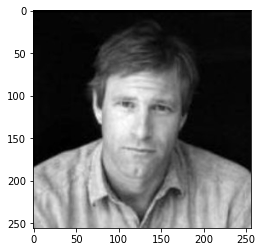

In [25]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [26]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [27]:
V = []
for key in images:
    for image in images[key]:
        U = np.reshape(image, (size**2, 1), "F")
        V.append(U)
M = np.concatenate(V, axis=1)

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [28]:
U, S, Vh = np.linalg.svd(M, full_matrices=False)

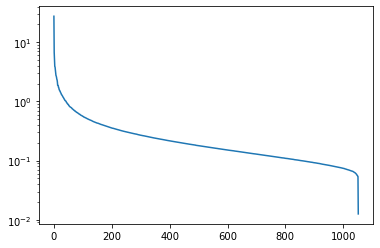

In [29]:
plt.semilogy(S)

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [30]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4,rows*4))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape((size, size), order="F"), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

In [31]:
S

array([2.75615482e+01, 6.76455206e+00, 5.07693126e+00, ...,
       5.44774274e-02, 5.37564903e-02, 1.25568514e-02])

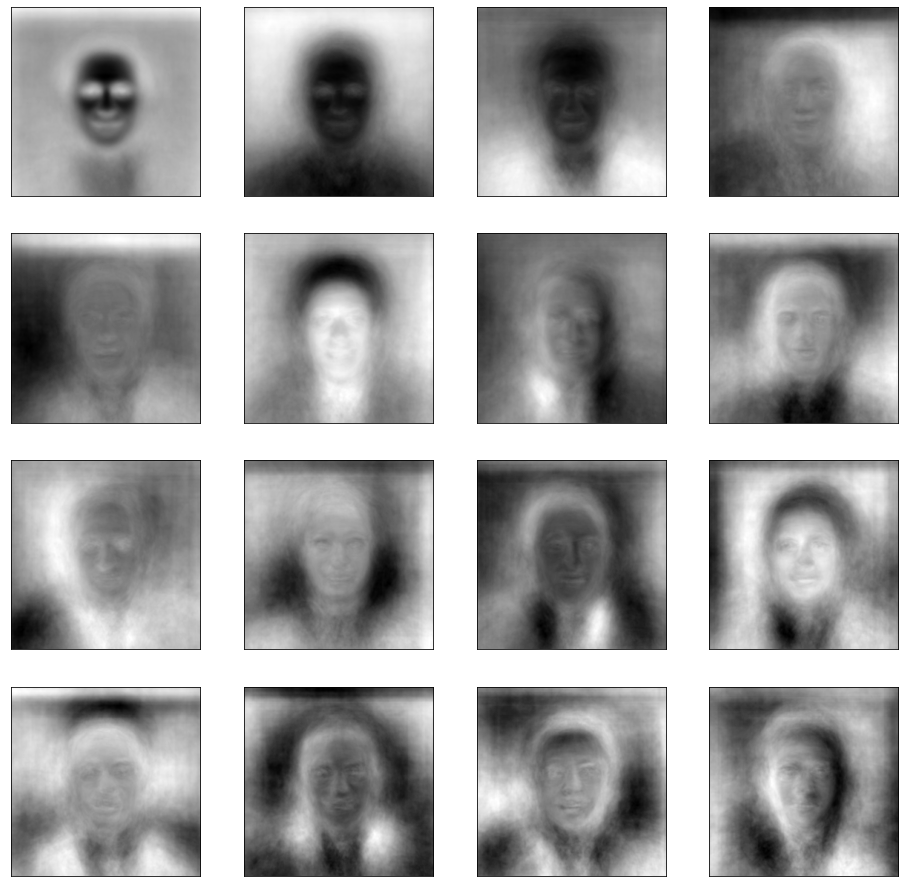

In [32]:
plot_as_images(U, 4, 4)

Три старших сингулярых вектора отвечают за наиболее часто встречающиеся и самые сильные закономерности, которые встречаются в наших лицах, 
они идут с наибольшим весом в линейные комбинации из базиса, который записан по столбцам U, а значит и больше всего влияют на итоговую картинку.

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [33]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation
            
        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    U1 = U[:, :r]
    S1 = S[:r]
    Vh1 = Vh[:r, :]
    C = np.multiply(Vh1, S1.reshape(S1.shape[0], 1))
    e = np.sum(S**2)
    e1 = np.sum(S1**2)
    return (U1, C, np.sqrt((e - e1)/e))

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [34]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 4, len(indices)* 4))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:, index].reshape((size, size), order="F"), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")
 
        appr = U @ C[:, index]
        axes[1].imshow(appr.reshape((size, size), order="F"), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:, i].reshape((size, size), order="F"), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

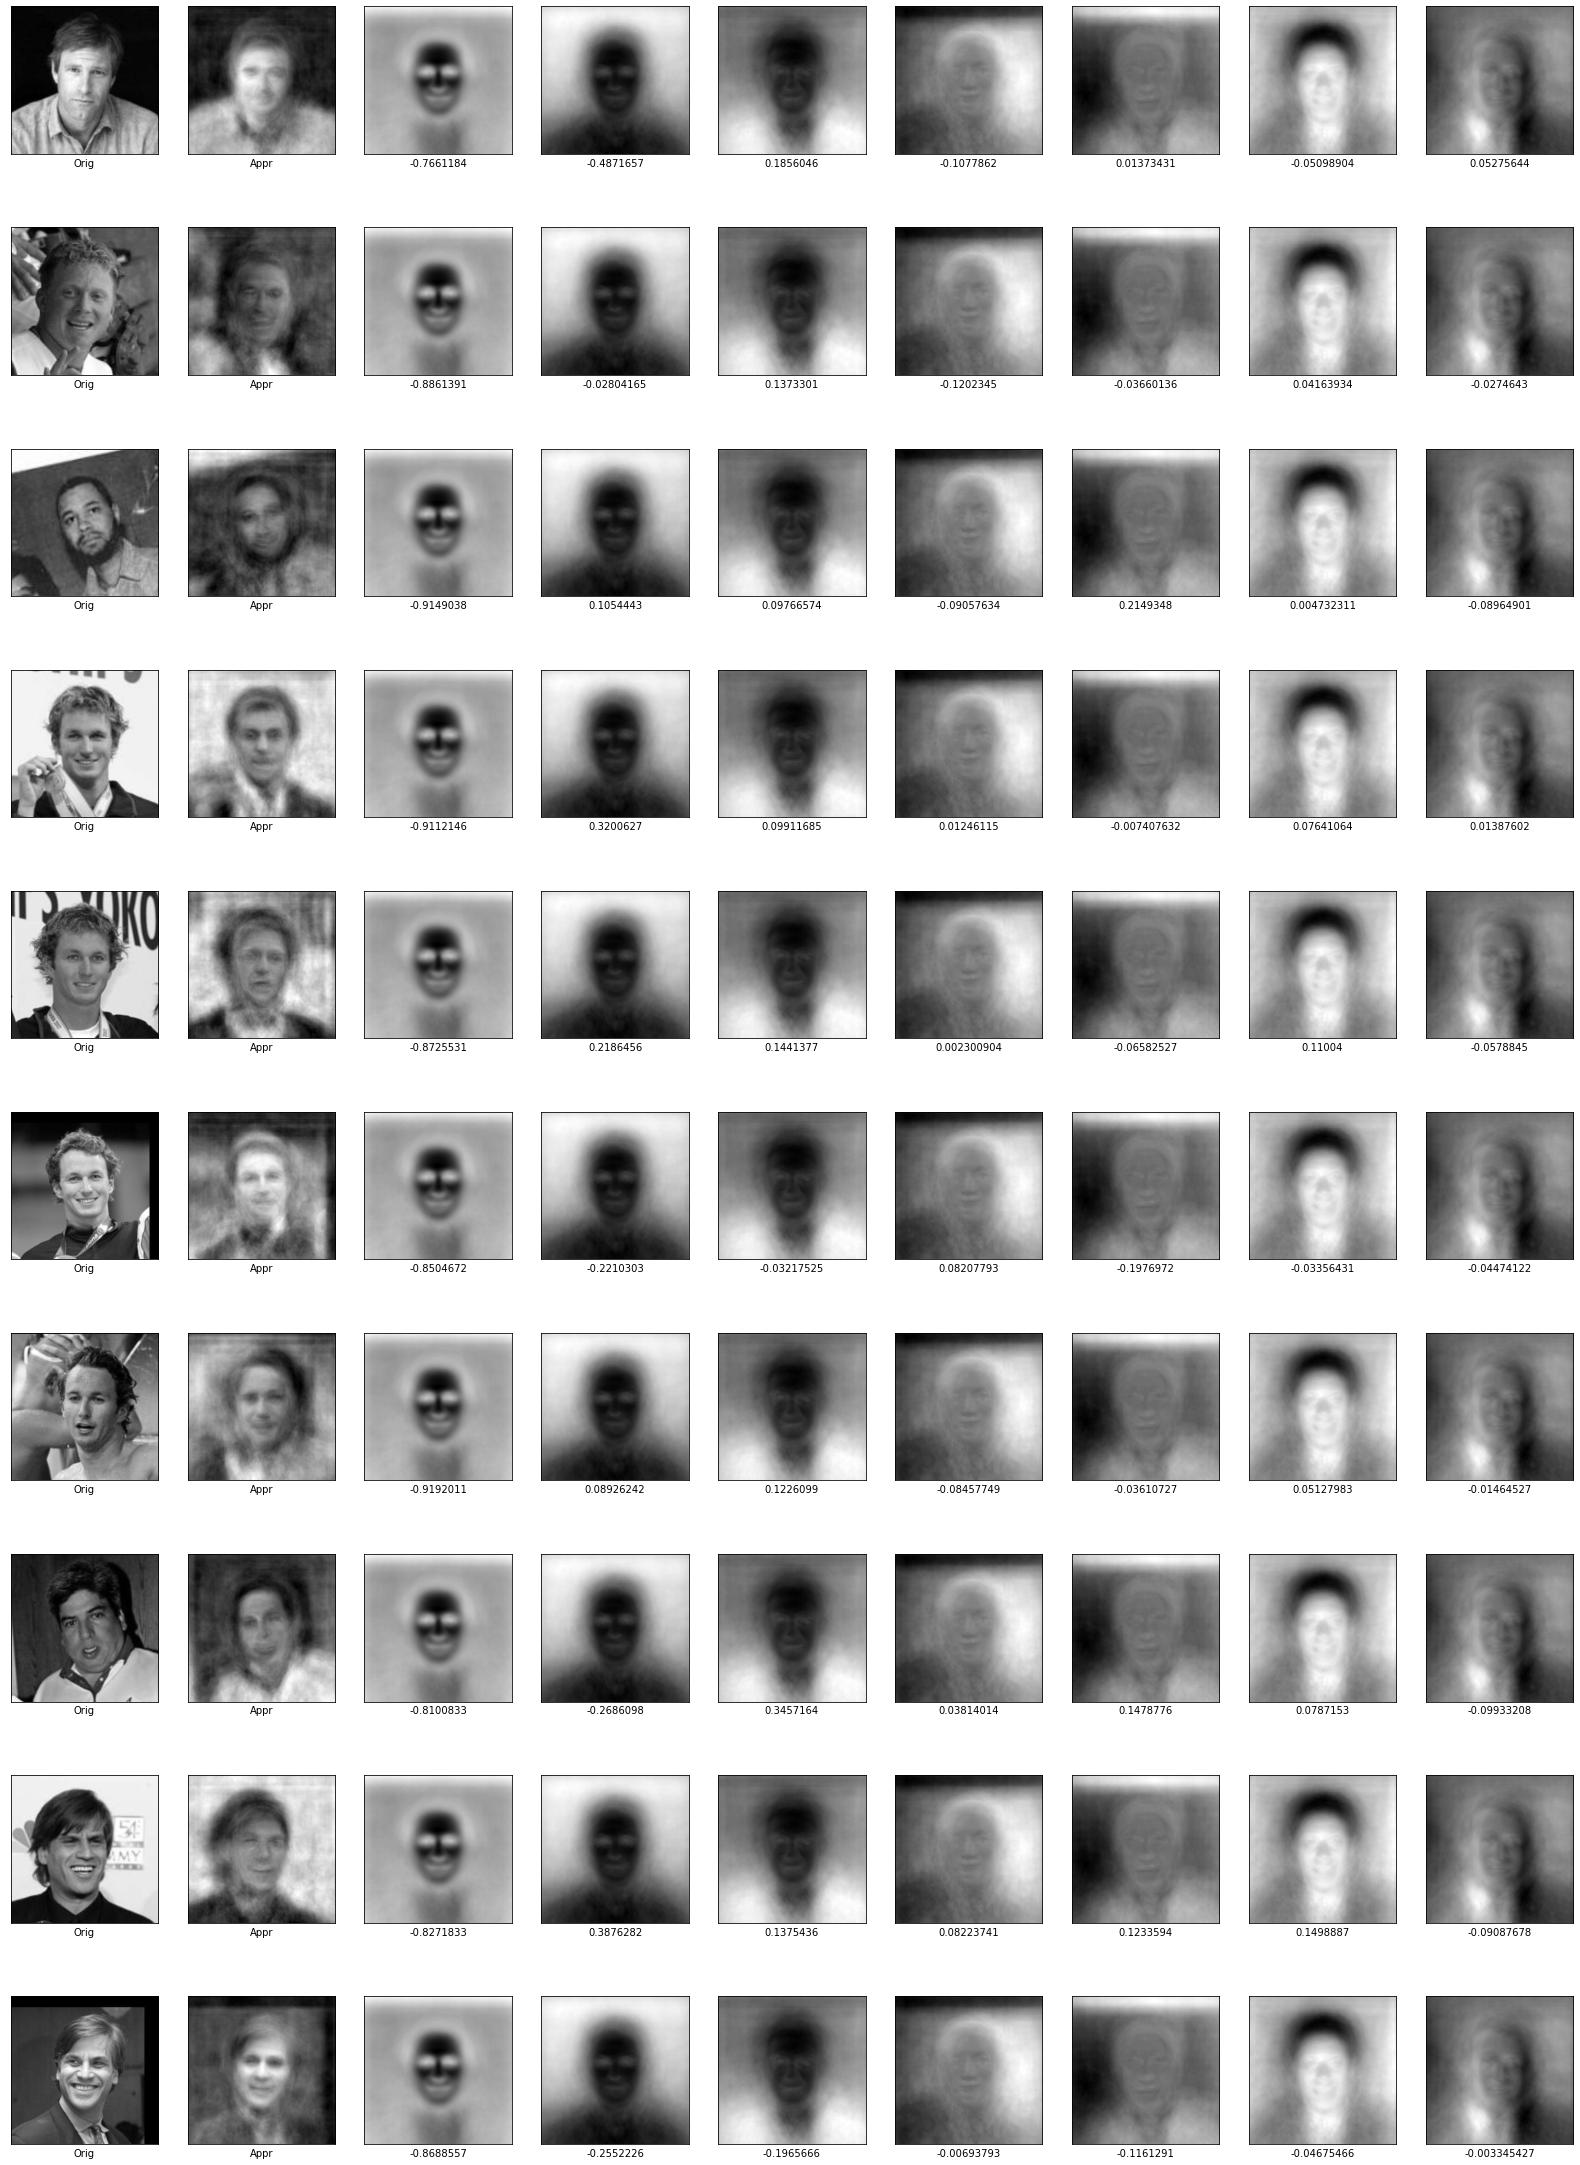

In [35]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [36]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    Omega = np.random.randn(M.shape[1], r + p)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    D = Q.T @ M
    W, S, Vh = np.linalg.svd(D, full_matrices=False)
    U = Q @ W
    U1 = U[:, :r]
    S1 = S[:r]
    Vh1 = Vh[:r, :]
    ans = U1 @ np.multiply(Vh1, S1.reshape((S1.shape[0], 1)))
    return ans, np.sqrt(np.sum((M - ans)**2)/np.sum(M**2))

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

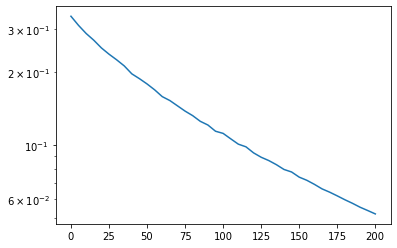

In [15]:
x = np.arange(0, 205, 5, dtype=int)
y = []
U, C, _ = trunc_svd(M, 50)
err1 = np.linalg.norm(U @ C - M)
for p in x:
    err2 =  sum((np.linalg.norm(rand_svd(M, 50, p)[0] - M) for i in range(10))) / 10
    y.append((err2 / err1) - 1)
plt.semilogy(x, y)

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [44]:
%timeit trunc_svd(M, 50)
%timeit rand_svd(M, 50)

5.24 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.15 s ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Примерно в 5 раз

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [38]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [39]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list of count indices of closest images
    """
    U = M - new_v.reshape(new_v.shape[0], 1)
    norms = np.sum(U**2, axis=0)
    sort_arg = np.argsort(norms)
    return sort_arg[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

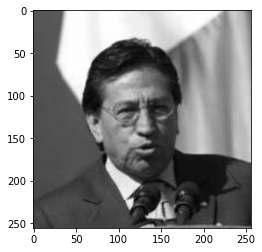

In [40]:
new = test_image
_ = plt.imshow(new, cmap="gray")

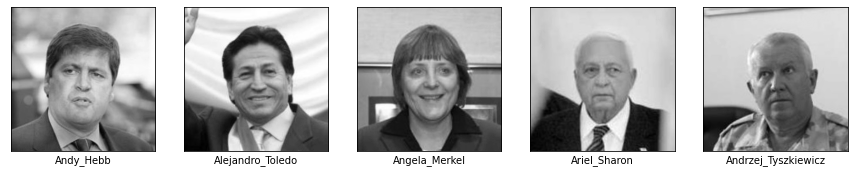

In [41]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [42]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list (of len `count`) of indices of closest images
    """
    v = U.T @ new_v
    A = C - v.reshape((v.shape[0], 1))
    A = A[1:,:]
    norms = np.sum(A**2, axis=0)
    sort_arg = np.argsort(norms)
    return sort_arg[:count]

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

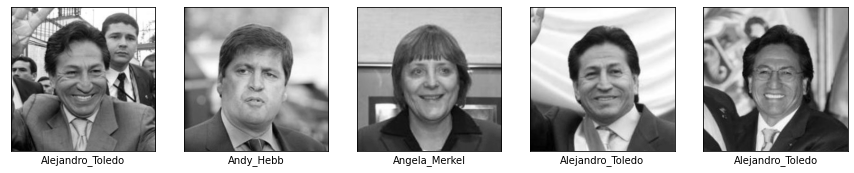

In [43]:
U, C, _ = trunc_svd(M, 50)
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

Для начала вставим сам алгоритм.

<img src="img1.png" style="width: 500px;">

Для начала заметим, что ранг матрицы $(A A^*)^q A$ равен рангу $A$, это мгновенно следует из разложения $A$ в SVD. 
Если $l < \mathrm{rank}{A}$, то тогда $(AA^*)A\Omega$ невырожденная матрица, если $\Omega$ -- гауссовская случайная матрица. Действительно, допустим, что мы уже выбрали $l - 1$ вектор $v_1, \ldots, v_{n-1}$ и они линейно независимы, тогда пространство решений $Ax = (v_1, \ldots, v_{n - 1})y$ не $n-$мерное, следовательно это пространство есть множество меры нуль в $\mathbb{R}^n$, 
а значит его вероятность линейной зависимости равна $0$.

Тогда матрица $(A A^*)^q A\Omega$ почти наверное имеет ранг равный $l$, и значит его ортонормированный базис имеет размерность $l$.

Теперь докажем, что в алгоритме 4.4 у нас получается матрица $Q$, которая является левой матрицей для некоторого QR разложения $(AA^*)^q A \Omega$.

Будем доказывать это для произвольного $q$ с использованием индукции.

Покажем по индукции, что для $i \in \{1, \ldots q\}$:

$$Q_q R_q \widetilde{R}_q \ldots R_i \widetilde{R}_i = (AA^*)^{q - i + 1} Q_{i - 1} $$

База для $i = q$.

$$Q_q R_q \widetilde{R}_q = A \widetilde{Q}_q \widetilde{R}_q = A A^* Q_{q - 1}$$

Теперь переход, если верно для $i + 1$ покажем для $i$.

$$Q_q R_q \widetilde{R}_q \ldots R_{i + 1} \widetilde{R}_{i+1} R_i \widetilde{R}_i = (A A^*)^{q - i} Q_{i}  R_i \widetilde{R}_i = (A A^*)^{q - i} A \widetilde{Q}_i \widetilde{R}_i = (A A^*)^{q - i} A A^* Q_{i - 1} =
(A A^*)^{q - i + 1} Q_{i - 1}$$

Хорошо, мы доказали, следовательно верно, что:

$$ Q_q R_q \widetilde{R}_q \ldots R_1 \widetilde{R}_1 R_0 = (AA^*)^{q} Q_{0} R_0 = (AA^*)^{q} A \Omega $$

Тогда заметим, что $Q_q$ и $R_q \widetilde{R}_q \ldots R_1 \widetilde{R}_1 R_0$ это матрицы QR-разложения $(AA^*)^{q} A \Omega$. Действительно, $Q_q$ имеет ортонормированные столбцы по построению, а $R_q \widetilde{R}_q \ldots R_1 \widetilde{R}_1 R_0$ это верхнетреугольная матрица, так как $Q_q$ по построению имеет $l$ столбцов (все тонкие $QR$-разложения имеют $l$-столбцов в матрице $Q$), то она действительно является $QR$-разложением, и в $Q$ по столбцам записан ортономированный базис $(AA^*)^{q} A \Omega$. Тогда, мы как раз получили в точности то что нам выдает алгоритм 4.3. Следовательно, алгоритмы 4.3 и 4.4 эквиваленты в точной арифметике.

In [23]:
# для начала функцию реализирующую алгоритм 4.4
def rand_q_mult(A, l, q):
    Omega = np.random.randn(M.shape[1], l)
    Y = A @ Omega
    Q, R = np.linalg.qr(Y)
    for i in range(q):
        Y_c = A.T @ Q
        Q_c, R_c = np.linalg.qr(Y_c)
        Y = A @ Q_c
        Q, R = np.linalg.qr(Y)
    return Q

In [24]:
def rand_svd_mult(A, l, q):
    Q = rand_q_mult(A, 2 * l, q) # беру 2l так как есть хорошая оценка, приложим ее чуть ниже
    D = Q.T @ A
    W, S, Vh = np.linalg.svd(D, full_matrices=False)
    U = Q @ W
    U1 = U[:, :l]
    S1 = S[:l]
    Vh1 = Vh[:l, :]
    ans = U1 @ np.multiply(Vh1, S1.reshape((S1.shape[0], 1)))
    return ans

<img src="img2.png" style="width: 500px;">

<img src="img3.png" style="width: 500px;">

<img src="img4.png" style="width: 500px;">

In [25]:
x = np.arange(0, 105, 5, dtype=int)
y = []
for r in [5, 20, 50]:
    U, C, _ = trunc_svd(M, r)
    M_1 = U @ C
    y.append([])
    for q in x:
        counter = 0
        for i in range(3):
            M_2 = rand_svd_mult(M, r, q)
            counter += np.linalg.norm(M_1 - M_2)
        y[-1].append(counter / 3)
    print(f"Ended r={r}")

Ended r=5
Ended r=20
Ended r=50


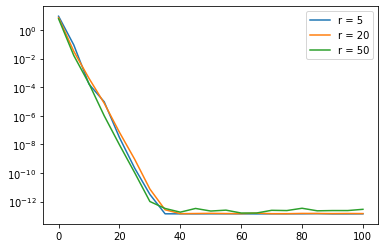

In [26]:
plt.plot(x, y[0], label = "r = 5")
plt.plot(x, y[1], label = "r = 20")
plt.plot(x, y[2], label = "r = 50")
plt.yscale("log")
plt.legend()